In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
tr = pd.read_parquet('train.parquet')
sample_submission = pd.read_csv('submission.csv')

In [3]:
df_distance = pd.read_csv('distance_from_to.csv')
df_distance

,from,to,cost
0,9,153,310.6
1,153,62,330.9
2,62,111,332.9
3,111,11,324.2
4,11,28,336.0
...,...,...,...
290,154,5,166.3
291,78,107,143.9
292,107,46,236.3
293,118,145,250.6


In [4]:
tr

,Values
0_0_0,133.0
0_0_1,114.0
0_0_2,140.0
0_0_3,106.0
0_0_4,117.0
...,...
169_2_17751,65.5
169_2_17752,65.5
169_2_17753,64.9
169_2_17754,64.7


In [5]:
index_split = tr.index.str.split('_')
index_split

Index([      ['0', '0', '0'],       ['0', '0', '1'],       ['0', '0', '2'],
             ['0', '0', '3'],       ['0', '0', '4'],       ['0', '0', '5'],
             ['0', '0', '6'],       ['0', '0', '7'],       ['0', '0', '8'],
             ['0', '0', '9'],
       ...
       ['169', '2', '17746'], ['169', '2', '17747'], ['169', '2', '17748'],
       ['169', '2', '17749'], ['169', '2', '17750'], ['169', '2', '17751'],
       ['169', '2', '17752'], ['169', '2', '17753'], ['169', '2', '17754'],
       ['169', '2', '17755']],
      dtype='object', length=9055560)

In [6]:
tr['row_num'] = index_split.str.get(0)
tr['row_type'] = index_split.str.get(1)
tr['timestamp'] = index_split.str.get(-1).astype(int)


In [7]:
tr

,Values,row_num,row_type,timestamp
0_0_0,133.0,0,0,0
0_0_1,114.0,0,0,1
0_0_2,140.0,0,0,2
0_0_3,106.0,0,0,3
0_0_4,117.0,0,0,4
...,...,...,...,...
169_2_17751,65.5,169,2,17751
169_2_17752,65.5,169,2,17752
169_2_17753,64.9,169,2,17753
169_2_17754,64.7,169,2,17754


In [8]:
tr['row_id'] = tr.row_num + '_' + tr.row_type # "уникальный" ряд - уникальная пара (row_num, row_type)
tr

,Values,row_num,row_type,timestamp,row_id
0_0_0,133.0,0,0,0,0_0
0_0_1,114.0,0,0,1,0_0
0_0_2,140.0,0,0,2,0_0
0_0_3,106.0,0,0,3,0_0
0_0_4,117.0,0,0,4,0_0
...,...,...,...,...,...
169_2_17751,65.5,169,2,17751,169_2
169_2_17752,65.5,169,2,17752,169_2
169_2_17753,64.9,169,2,17753,169_2
169_2_17754,64.7,169,2,17754,169_2


In [9]:
def calculate_weights(data):
    """
    Функция для расчета весов для каждого ряда
    """
    weights = []
    for i in range(data.shape[0]):
        ts = data.values[i, :]
        weight = np.mean(np.abs(np.diff(ts)))
        weights.append(1 / weight)
    return np.array(weights)


def calculate_mase(y_true, y_pred, weight):
    """
    Функция для расчета метрики MASE для каждого ряда
    """
    n = len(y_true)
    mase = np.sum(weight * np.abs(y_true - y_pred)) / n
    return mase

In [10]:
X = tr.pivot(index='row_id', columns='timestamp', values='Values')
X.columns = ['tr_' + str(col) for col in X.columns]
X

,tr_0,tr_1,tr_2,tr_3,tr_4,tr_5,tr_6,tr_7,tr_8,tr_9,...,tr_17746,tr_17747,tr_17748,tr_17749,tr_17750,tr_17751,tr_17752,tr_17753,tr_17754,tr_17755
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,133.0000,114.0000,140.0000,106.0000,117.0000,110.0000,130.0000,112.0000,115.0000,93.0000,...,446.0000,468.0000,447.0000,443.0000,476.0000,509.0000,462.0000,412.0000,429.0000,430.0000
0_1,0.0603,0.0532,0.0622,0.0452,0.0574,0.0545,0.0566,0.0606,0.0479,0.0477,...,0.1498,0.1595,0.1527,0.1491,0.1554,0.1643,0.1621,0.1450,0.1480,0.1488
0_2,65.8000,66.9000,66.8000,68.9000,67.4000,65.5000,66.4000,63.0000,67.3000,65.7000,...,61.6000,61.7000,61.8000,62.5000,62.4000,62.7000,62.7000,62.5000,62.3000,61.8000
100_0,124.0000,125.0000,127.0000,121.0000,121.0000,132.0000,124.0000,116.0000,116.0000,118.0000,...,261.0000,281.0000,222.0000,254.0000,284.0000,286.0000,264.0000,281.0000,288.0000,291.0000
100_1,0.0493,0.0475,0.0486,0.0481,0.0478,0.0496,0.0446,0.0467,0.0443,0.0494,...,0.0873,0.0932,0.0763,0.0874,0.0970,0.0905,0.0824,0.0915,0.0985,0.1079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.0472,0.0425,0.0491,0.0449,0.0421,0.0526,0.0474,0.0495,0.0403,0.0504,...,0.0848,0.0901,0.0935,0.0825,0.0894,0.0941,0.0950,0.0864,0.0924,0.0833
99_2,64.1000,63.4000,62.2000,62.4000,64.3000,61.4000,61.1000,59.1000,61.0000,57.9000,...,58.4000,56.8000,58.0000,58.9000,57.8000,58.4000,57.3000,57.5000,57.0000,59.3000
9_0,256.0000,210.0000,224.0000,208.0000,188.0000,211.0000,178.0000,189.0000,169.0000,171.0000,...,670.0000,789.0000,769.0000,655.0000,690.0000,732.0000,684.0000,684.0000,724.0000,744.0000


In [11]:
weights = calculate_weights(X)
weights

array([4.46829661e-02, 1.08474315e+02, 9.76150158e-01, 7.81473510e-02,
       1.51608044e+02, 8.67489776e-01, 5.28749940e-02, 1.72946341e+02,
       9.89461717e-01, 1.11539694e-01, 1.12995393e+02, 1.30151446e+00,
       1.10823986e-01, 1.06672322e+02, 1.28476946e+00, 4.67683603e-02,
       1.66899320e+02, 1.88106539e+00, 9.70738428e-02, 2.37187785e+02,
       3.02079080e+00, 3.30337258e-02, 1.34956100e+02, 1.41491015e+00,
       5.66073228e-02, 1.66079394e+02, 1.60975919e+00, 1.73964590e-01,
       2.06317942e+02, 2.56890689e+00, 3.78039433e-01, 6.15303042e+02,
       4.20993977e+00, 3.28792034e-02, 1.58668170e+02, 1.01270227e+00,
       1.04030562e-01, 1.89605699e+02, 5.25218163e+00, 4.87193840e-02,
       1.48121637e+02, 9.07390467e-01, 6.33647748e-02, 1.23514246e+02,
       1.17985181e+00, 8.06664122e-02, 1.71370219e+02, 1.54502815e+00,
       1.41849354e-01, 1.89661803e+02, 6.68579584e-01, 1.88754465e-01,
       6.15303042e+02, 4.08649420e+00, 1.23325160e-01, 3.10530762e+02,
      

In [12]:
for i in range(100):
    X.loc[:, f'pred_{i}'] =(X.iloc[:,-2016])  # предсказываем "100 таймстемпов назад"

X.iloc[:, -105:]

C:\Users\Senya\AppData\Local\Temp\ipykernel_17404\1844724297.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X.loc[:, f'pred_{i}'] =(X.iloc[:,-2016])  # предсказываем "100 таймстемпов назад"


,tr_17751,tr_17752,tr_17753,tr_17754,tr_17755,pred_0,pred_1,pred_2,pred_3,pred_4,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,509.0000,462.0000,412.0000,429.0000,430.0000,446.0000,475.0000,461.0000,459.0000,435.0000,...,148.0000,127.0000,121.0000,115.0000,111.0000,129.0000,130.0000,128.0000,121.0000,115.0000
0_1,0.1643,0.1621,0.1450,0.1480,0.1488,0.1455,0.1500,0.1517,0.1612,0.1304,...,0.0635,0.0612,0.0549,0.0546,0.0529,0.0622,0.0593,0.0671,0.0569,0.0571
0_2,62.7000,62.7000,62.5000,62.3000,61.8000,63.1000,63.6000,63.6000,62.7000,65.1000,...,68.9000,65.9000,66.5000,66.4000,64.6000,64.4000,64.9000,62.8000,62.9000,63.2000
100_0,286.0000,264.0000,281.0000,288.0000,291.0000,294.0000,307.0000,323.0000,299.0000,293.0000,...,124.0000,159.0000,133.0000,146.0000,128.0000,130.0000,121.0000,132.0000,124.0000,132.0000
100_1,0.0905,0.0824,0.0915,0.0985,0.1079,0.0998,0.1332,0.1087,0.1224,0.1973,...,0.0470,0.0589,0.0520,0.0526,0.0464,0.0477,0.0477,0.0514,0.0455,0.0473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.0941,0.0950,0.0864,0.0924,0.0833,0.1011,0.0942,0.0995,0.1006,0.0965,...,0.0469,0.0561,0.0486,0.0474,0.0439,0.0451,0.0421,0.0462,0.0347,0.0397
99_2,58.4000,57.3000,57.5000,57.0000,59.3000,56.6000,59.2000,59.8000,58.6000,57.9000,...,65.3000,59.8000,60.5000,59.2000,60.7000,61.3000,63.8000,63.4000,64.1000,63.8000
9_0,732.0000,684.0000,684.0000,724.0000,744.0000,633.0000,628.0000,611.0000,617.0000,676.0000,...,248.0000,265.0000,222.0000,278.0000,218.0000,211.0000,203.0000,217.0000,189.0000,183.0000


In [13]:
X.iloc[0]

tr_0       133.0
tr_1       114.0
tr_2       140.0
tr_3       106.0
tr_4       117.0
           ...  
pred_95    129.0
pred_96    130.0
pred_97    128.0
pred_98    121.0
pred_99    115.0
Name: 0_0, Length: 17856, dtype: float64

In [14]:
# !pip install statsforecast

In [15]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA

sf = StatsForecast(
    models = [AutoARIMA(season_length = 2016)],
    freq = '5T'
)

C:\Users\Senya\anaconda3\Lib\site-packages\statsforecast\core.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [16]:
import pandas as pd
import datetime
  
# range of dates
date_range = pd.period_range(
    start=datetime.datetime.today(), periods=17856, freq='5T')
  
# timestamp range
timestamp_range = [x.to_timestamp() for x in date_range]
  

In [17]:
train = pd.DataFrame({'unique_id':'1_r', 'ds':timestamp_range,'y':X.iloc[0]})
train= train.tail(4031)

In [18]:
sf.fit(train)

StatsForecast(models=[AutoARIMA])

In [19]:
predd = sf.predict(h=100)
predd

C:\Users\Senya\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


,ds,AutoARIMA
unique_id,,
1_r,2024-04-08 14:20:00,118.619553
1_r,2024-04-08 14:25:00,118.463165
1_r,2024-04-08 14:30:00,118.306984
1_r,2024-04-08 14:35:00,118.151009
1_r,2024-04-08 14:40:00,117.995239
...,...,...
1_r,2024-04-08 22:15:00,104.646858
1_r,2024-04-08 22:20:00,104.508888
1_r,2024-04-08 22:25:00,104.371109


C:\Users\Senya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Senya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Senya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Senya\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

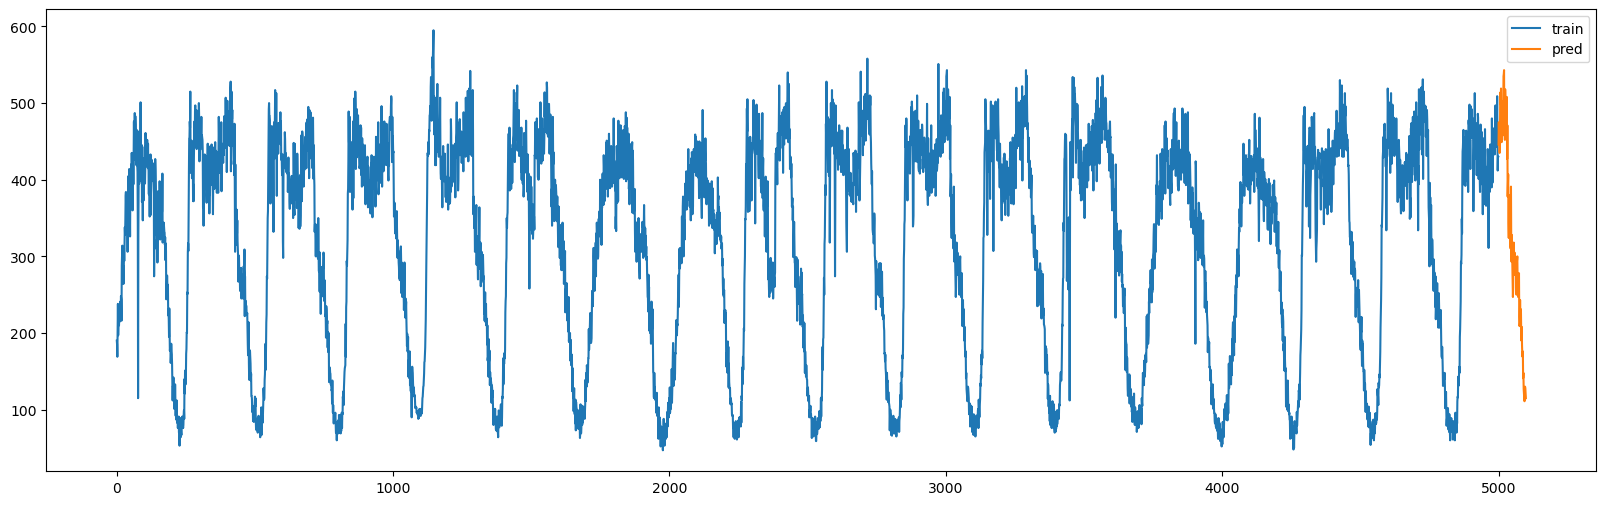

In [20]:
# нарисуем хвост из 5100 значений вместе с предсказанными
hue_col = ['train'] * 5000 + ['pred'] * 100

import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x=np.arange(5100), y=X.iloc[0, -5100:].values, hue=hue_col, n_boot=0)
plt.gcf().set_size_inches(20, 6)

In [21]:
from IPython.display import display

display(X.iloc[:, -100:])
sample_submission.head(3)

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,446.0000,475.0000,461.0000,459.0000,435.0000,445.0000,509.0000,514.0000,498.0000,519.0000,...,148.0000,127.0000,121.0000,115.0000,111.0000,129.0000,130.0000,128.0000,121.0000,115.0000
0_1,0.1455,0.1500,0.1517,0.1612,0.1304,0.1425,0.1646,0.1538,0.1541,0.1550,...,0.0635,0.0612,0.0549,0.0546,0.0529,0.0622,0.0593,0.0671,0.0569,0.0571
0_2,63.1000,63.6000,63.6000,62.7000,65.1000,64.8000,64.1000,65.1000,64.3000,64.5000,...,68.9000,65.9000,66.5000,66.4000,64.6000,64.4000,64.9000,62.8000,62.9000,63.2000
100_0,294.0000,307.0000,323.0000,299.0000,293.0000,316.0000,292.0000,321.0000,292.0000,316.0000,...,124.0000,159.0000,133.0000,146.0000,128.0000,130.0000,121.0000,132.0000,124.0000,132.0000
100_1,0.0998,0.1332,0.1087,0.1224,0.1973,0.1800,0.2309,0.1967,0.2013,0.1440,...,0.0470,0.0589,0.0520,0.0526,0.0464,0.0477,0.0477,0.0514,0.0455,0.0473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.1011,0.0942,0.0995,0.1006,0.0965,0.0939,0.0971,0.0934,0.0809,0.0844,...,0.0469,0.0561,0.0486,0.0474,0.0439,0.0451,0.0421,0.0462,0.0347,0.0397
99_2,56.6000,59.2000,59.8000,58.6000,57.9000,59.2000,60.4000,60.3000,60.5000,60.7000,...,65.3000,59.8000,60.5000,59.2000,60.7000,61.3000,63.8000,63.4000,64.1000,63.8000
9_0,633.0000,628.0000,611.0000,617.0000,676.0000,650.0000,651.0000,669.0000,682.0000,645.0000,...,248.0000,265.0000,222.0000,278.0000,218.0000,211.0000,203.0000,217.0000,189.0000,183.0000


,Id,Expected
0,0_0_0,0.0
1,0_0_1,0.0
2,0_0_2,0.0


In [22]:
X_pred = X.iloc[:, -100:]
X_pred

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,446.0000,475.0000,461.0000,459.0000,435.0000,445.0000,509.0000,514.0000,498.0000,519.0000,...,148.0000,127.0000,121.0000,115.0000,111.0000,129.0000,130.0000,128.0000,121.0000,115.0000
0_1,0.1455,0.1500,0.1517,0.1612,0.1304,0.1425,0.1646,0.1538,0.1541,0.1550,...,0.0635,0.0612,0.0549,0.0546,0.0529,0.0622,0.0593,0.0671,0.0569,0.0571
0_2,63.1000,63.6000,63.6000,62.7000,65.1000,64.8000,64.1000,65.1000,64.3000,64.5000,...,68.9000,65.9000,66.5000,66.4000,64.6000,64.4000,64.9000,62.8000,62.9000,63.2000
100_0,294.0000,307.0000,323.0000,299.0000,293.0000,316.0000,292.0000,321.0000,292.0000,316.0000,...,124.0000,159.0000,133.0000,146.0000,128.0000,130.0000,121.0000,132.0000,124.0000,132.0000
100_1,0.0998,0.1332,0.1087,0.1224,0.1973,0.1800,0.2309,0.1967,0.2013,0.1440,...,0.0470,0.0589,0.0520,0.0526,0.0464,0.0477,0.0477,0.0514,0.0455,0.0473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.1011,0.0942,0.0995,0.1006,0.0965,0.0939,0.0971,0.0934,0.0809,0.0844,...,0.0469,0.0561,0.0486,0.0474,0.0439,0.0451,0.0421,0.0462,0.0347,0.0397
99_2,56.6000,59.2000,59.8000,58.6000,57.9000,59.2000,60.4000,60.3000,60.5000,60.7000,...,65.3000,59.8000,60.5000,59.2000,60.7000,61.3000,63.8000,63.4000,64.1000,63.8000
9_0,633.0000,628.0000,611.0000,617.0000,676.0000,650.0000,651.0000,669.0000,682.0000,645.0000,...,248.0000,265.0000,222.0000,278.0000,218.0000,211.0000,203.0000,217.0000,189.0000,183.0000


In [23]:
X_pred.iloc[0] = predd.AutoARIMA

In [24]:
X_pred

,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,...,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99
row_id,,,,,,,,,,,,,,,,,,,,,
0_0,118.619553,118.463165,118.306984,118.151009,117.995239,117.839676,117.684311,117.52916,117.374214,117.219467,...,105.339417,105.200539,105.061844,104.923332,104.785004,104.646858,104.508888,104.371109,104.233505,104.096085
0_1,0.145500,0.150000,0.151700,0.161200,0.130400,0.142500,0.164600,0.15380,0.154100,0.155000,...,0.063500,0.061200,0.054900,0.054600,0.052900,0.062200,0.059300,0.067100,0.056900,0.057100
0_2,63.100000,63.600000,63.600000,62.700000,65.100000,64.800000,64.100000,65.10000,64.300000,64.500000,...,68.900000,65.900000,66.500000,66.400000,64.600000,64.400000,64.900000,62.800000,62.900000,63.200000
100_0,294.000000,307.000000,323.000000,299.000000,293.000000,316.000000,292.000000,321.00000,292.000000,316.000000,...,124.000000,159.000000,133.000000,146.000000,128.000000,130.000000,121.000000,132.000000,124.000000,132.000000
100_1,0.099800,0.133200,0.108700,0.122400,0.197300,0.180000,0.230900,0.19670,0.201300,0.144000,...,0.047000,0.058900,0.052000,0.052600,0.046400,0.047700,0.047700,0.051400,0.045500,0.047300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99_1,0.101100,0.094200,0.099500,0.100600,0.096500,0.093900,0.097100,0.09340,0.080900,0.084400,...,0.046900,0.056100,0.048600,0.047400,0.043900,0.045100,0.042100,0.046200,0.034700,0.039700
99_2,56.600000,59.200000,59.800000,58.600000,57.900000,59.200000,60.400000,60.30000,60.500000,60.700000,...,65.300000,59.800000,60.500000,59.200000,60.700000,61.300000,63.800000,63.400000,64.100000,63.800000
9_0,633.000000,628.000000,611.000000,617.000000,676.000000,650.000000,651.000000,669.00000,682.000000,645.000000,...,248.000000,265.000000,222.000000,278.000000,218.000000,211.000000,203.000000,217.000000,189.000000,183.000000


In [25]:
print(len(weights))

510


In [26]:
calculate_mase(X_pred.iloc[:, 0],X_pred.iloc[:, 0], weights)

0.0

In [27]:
'''
Чтобы превратить наш X обратно в столбец, есть .melt
'''
res = X.iloc[:, -100:].melt(ignore_index=False, value_name='Expected', var_name='pred_timestamp')
res

,pred_timestamp,Expected
row_id,,
0_0,pred_0,446.0000
0_1,pred_0,0.1455
0_2,pred_0,63.1000
100_0,pred_0,294.0000
100_1,pred_0,0.0998
...,...,...
99_1,pred_99,0.0397
99_2,pred_99,63.8000
9_0,pred_99,183.0000


In [28]:
'''
Движемся в правильную сторону, но нужно немного поработать
'''
index_split_res = res.index.str.split('_')
res['row_num'] = index_split_res.str.get(0).astype(int)
res['row_type'] = index_split_res.str.get(1).astype(int)
res['timestamp'] = res.pred_timestamp.str.split('_').str.get(1).astype(int)
res['Id'] = res.index + '_' + res.timestamp.astype(str)
res.sort_values(['row_num', 'row_type', 'timestamp'], inplace=True)
res

,pred_timestamp,Expected,row_num,row_type,timestamp,Id
row_id,,,,,,
0_0,pred_0,446.0,0,0,0,0_0_0
0_0,pred_1,475.0,0,0,1,0_0_1
0_0,pred_2,461.0,0,0,2,0_0_2
0_0,pred_3,459.0,0,0,3,0_0_3
0_0,pred_4,435.0,0,0,4,0_0_4
...,...,...,...,...,...,...
169_2,pred_95,65.1,169,2,95,169_2_95
169_2,pred_96,65.2,169,2,96,169_2_96
169_2,pred_97,65.1,169,2,97,169_2_97


In [29]:
sample_submission = res[['Id', 'Expected']].reset_index(drop=True)
sample_submission[sample_submission.Expected == 476]

,Id,Expected
1814,6_0_14,476.0
7834,26_0_34,476.0
7845,26_0_45,476.0
13819,46_0_19,476.0
15634,52_0_34,476.0
40224,134_0_24,476.0
40240,134_0_40,476.0
40809,136_0_9,476.0
45611,152_0_11,476.0
45939,153_0_39,476.0


In [30]:
sample_submission.to_csv('submission2016_1strow_autoarima.csv', index=False)

In [33]:
sample_submission

,Id,Expected
0,0_0_0,446.0
1,0_0_1,475.0
2,0_0_2,461.0
3,0_0_3,459.0
4,0_0_4,435.0
...,...,...
50995,169_2_95,65.1
50996,169_2_96,65.2
50997,169_2_97,65.1
50998,169_2_98,65.0


In [34]:
# !kaggle competitions submit -c aim-2023 -f submission2016_1strow_autoarima.csv -m "M"